# Importing library

In [1]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow
import pandas as pd

import pandas as pd
import numpy as np
import cv2
import os
import re
import time

from sklearn.model_selection import GroupKFold


!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torch.utils.data import DataLoader, Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 5.2 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=d91e25cd528adf68b2b00c08925e29800542e2a5ff934130b0ac5037de260a4c
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


#data download

In [2]:
!cp /content/drive/MyDrive/KDT/offline/project/augmentation_dataset/cocoset_b.zip .

In [3]:
!unzip -qq cocoset_b.zip

In [4]:
!rm ./cocoset_b.zip

#validation file & training file 합치기

수현님이 준 COCO dataset 형식을 Pascal VOC형식으로 만들어 줘야함.

내가 쓰는 코드안에 group k fold로 train과 valid set을 나눠주기때문에 미리 나눠질 필요가 없다. 그러므로 나눠져있는 validation file과 training file을 합치는 작업 필요.

### IMAGE 처리
1) train 폴더내 데이터 이름과 val 폴더내 데이터 이름이 겹치기때문에 val 폴더에 있는 데이터 이름 바꿔주기

In [5]:
templist = os.listdir('/content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/val2017/')
newlist = []
for i in templist:
  id = i.split('.')[0]
  newlist.append(id+'_val.jpg')

In [6]:
for i in templist:
  os.rename('/content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/val2017/'+i, '/content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/val2017/'+i.split('.')[0]+'_val.jpg')

2) 한폴더에 합치기

In [7]:
%mv /content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/val2017/* /content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/train2017/

In [8]:
!rm -r /content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/val2017 

### DATAFRAME 만들기
1) training json file loading

In [9]:
import json
with open('/content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/annotations/instances_train2017.json', 'r') as f:
  json_data = json.load(f)

json_data['images'] #file_name, height, width -> 12,304개

json_data['annotations'] #area, bbox, category_id, segmentation -> 101,140개

2) 파일 이름 당 필요한 데이터 한 dictionary에 모으기

In [10]:
new_dict = {}

for i in tqdm(range(len(json_data['images']))):
  temp_dict = {
      'image_id':[],
      'categoryid':[],
      'bbox':[]
      }
  img_name = json_data['images'][i]['file_name']
  img_id = json_data['images'][i]['id']
  for j in json_data['annotations']:
    if j['image_id'] == img_id:
      temp_dict['image_id'].append(img_id)
      temp_dict['bbox'].append(j['bbox'])
      temp_dict['categoryid'].append(j['category_id'])
  new_dict[img_name] = temp_dict

  0%|          | 0/12304 [00:00<?, ?it/s]

new_dict

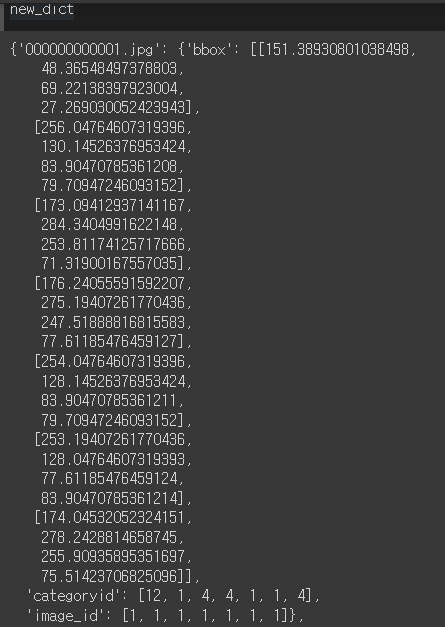

In [11]:
tempdf = pd.DataFrame(new_dict)
#행,열 바꾸기
tempdf = tempdf.transpose()
tempdf = tempdf[['categoryid', 'bbox']]
tempdf = tempdf.rename_axis('image_id').reset_index()

3) bbox 하나씩있는 파일 만들기

In [ ]:
content_list = []
index_list = []
columns = ['image_id', 'category', 'xmid', 'ymid', 'w', 'h']
num = 0
for i in tqdm(range(12304)):
    info = tempdf.iloc[i] #행 가져오기
    box_len = len(info.categoryid) #bbox개수
    for j in range(box_len):
        temp_list = []
        #print(tempdf.iloc[i]['categoryid'][j]) -> 12
        temp_list.append(tempdf.iloc[i]['image_id'].split('.')[0])
        temp_list.append(tempdf.iloc[i]['categoryid'][j])
        temp_list.append(tempdf.iloc[i]['bbox'][j][0])
        temp_list.append(tempdf.iloc[i]['bbox'][j][1])
        temp_list.append(tempdf.iloc[i]['bbox'][j][2])
        temp_list.append(tempdf.iloc[i]['bbox'][j][3])
        #print(temp_list) -> [imgname, category, xmid, ymid, w, h]
        #break
        content_list.append(temp_list)
        index_list.append(num)
        num += 1

100%|██████████| 12304/12304 [00:39<00:00, 312.25it/s]


In [ ]:
final_df = pd.DataFrame(content_list, index = index_list, columns = columns)

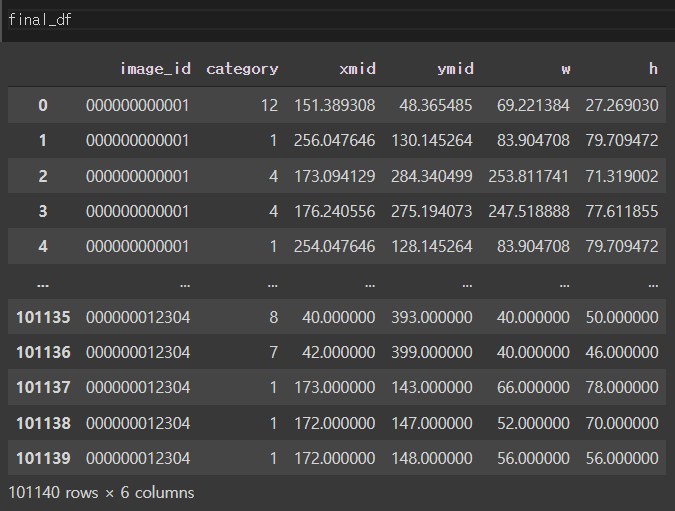

4) xmin,ymin,xmax,ymax만들기

In [ ]:
final_df['xmin'] = final_df['xmid'] - final_df['w'] / 2
final_df['ymin'] = final_df['ymid'] - final_df['h'] / 2
final_df['xmax'] = final_df['xmid'] + final_df['w'] / 2
final_df['ymax'] = final_df['ymid'] + final_df['h'] / 2

In [ ]:
final_df = final_df[['image_id', 'category', 'xmin', 'ymin', 'xmax', 'ymax']]

In [ ]:
final_df.category.unique()

array([12,  1,  4, 10,  9,  5,  8,  7, 11, 14,  3,  6,  2, 13])

5) 음수값 제거

In [ ]:
final_df.loc[final_df['xmin'] < 0, 'xmin'] =  0 #[행 selection, 열 selection]

In [ ]:
final_df.loc[final_df['ymin'] < 0, 'ymin'] =  0 #[행 selection, 열 selection]

6) validation json loading

In [ ]:
with open('/content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/annotations/instances_val2017.json', 'r') as fv:
  val_json_data = json.load(fv)

val_json_data['images'] #file_name, height, width -> 5,272

val_json_data['annotations'] #area, bbox, category_id, segmentation -> 43,244

In [ ]:
val_new_dict = {}

for i in tqdm(range(len(val_json_data['images']))):
  temp_dict = {
      'image_id':[],
      'categoryid':[],
      'bbox':[]
      }
  img_name = val_json_data['images'][i]['file_name']
  img_id = val_json_data['images'][i]['id']
  for j in val_json_data['annotations']:
    if j['image_id'] == img_id:
      temp_dict['image_id'].append(img_id)
      temp_dict['bbox'].append(j['bbox'])
      temp_dict['categoryid'].append(j['category_id'])
  val_new_dict[img_name] = temp_dict

100%|██████████| 5272/5272 [00:28<00:00, 183.96it/s]


In [ ]:
val_tempdf = pd.DataFrame(val_new_dict)
#행,열 바꾸기
val_tempdf = val_tempdf.transpose()
val_tempdf = val_tempdf[['categoryid', 'bbox']]
val_tempdf = val_tempdf.rename_axis('image_id').reset_index()

In [ ]:
content_list = []
index_list = []
columns = ['image_id', 'category', 'xmid', 'ymid', 'w', 'h']
num = 0
for i in tqdm(range(5272)):
    info = val_tempdf.iloc[i] #행 가져오기
    box_len = len(info.categoryid) #bbox개수
    for j in range(box_len):
        temp_list = []
        #print(tempdf.iloc[i]['categoryid'][j]) -> 12
        temp_list.append(val_tempdf.iloc[i]['image_id'].split('.')[0])
        temp_list.append(val_tempdf.iloc[i]['categoryid'][j])
        temp_list.append(val_tempdf.iloc[i]['bbox'][j][0])
        temp_list.append(val_tempdf.iloc[i]['bbox'][j][1])
        temp_list.append(val_tempdf.iloc[i]['bbox'][j][2])
        temp_list.append(val_tempdf.iloc[i]['bbox'][j][3])
        #print(temp_list) -> [imgname, category, xmid, ymid, w, h]
        #break
        content_list.append(temp_list)
        index_list.append(num)
        num += 1

100%|██████████| 5272/5272 [00:16<00:00, 310.77it/s]


print(len(content_list), len(index_list)) -> 43,244

In [ ]:
val_df = pd.DataFrame(content_list, index = index_list, columns = columns)

In [ ]:
val_df['xmin'] = val_df['xmid'] - val_df['w'] / 2
val_df['ymin'] = val_df['ymid'] - val_df['h'] / 2
val_df['xmax'] = val_df['xmid'] + val_df['w'] / 2
val_df['ymax'] = val_df['ymid'] + val_df['h'] / 2

In [ ]:
val_df = val_df[['image_id', 'category', 'xmin', 'ymin', 'xmax', 'ymax']]

In [ ]:
#x값에 음수가 있다면 0값으로 처리해라
val_df.loc[val_df['xmin'] < 0, 'xmin'] =  0 #[행 selection, 열 selection]

In [ ]:
#y값에 음수가 있다면 0값으로 처리해라
val_df.loc[val_df['ymin'] < 0, 'ymin'] =  0 #[행 selection, 열 selection]

In [ ]:
val_df['image_id'] = val_df.apply(lambda row: row.image_id + '_val', axis = 1)

7) train df + val df

In [ ]:
total_df = pd.concat([final_df, val_df], axis=0, ignore_index=True)
total_df = total_df[total_df['ymin'] != total_df['ymax']].reset_index()

In [ ]:
total_df.drop('index',axis=1)

,image_id,category,xmin,ymin,xmax,ymax
0,000000000001,12,116.778616,34.730970,186.000000,62.000000
1,000000000001,1,214.095292,90.290528,298.000000,170.000000
2,000000000001,4,46.188259,248.680998,300.000000,320.000000
3,000000000001,4,52.481112,236.388145,300.000000,314.000000
4,000000000001,1,212.095292,88.290528,296.000000,168.000000
...,...,...,...,...,...,...
144373,000000005272_val,4,108.315079,60.905434,169.386347,300.145486
144374,000000005272_val,1,246.205551,241.430894,328.402101,315.481386
144375,000000005272_val,1,280.198050,246.141207,346.262566,315.152760
144376,000000005272_val,4,90.550638,58.166881,168.714179,301.131365
